# Projeto de Análise de Rede Social Twitter

**Disciplina:** Teoria e Aplicação de Grafos, Turma 01, 2025/1
**Professor:** Díbio
**Integrantes:**
* Luiz Henrique Silva de Andrade - 211010430
* Marcelo Marques Rodrigues - 221018960
* Ryan Reis Fontenele - 211036132

**Objetivo:** Este projeto visa analisar estruturas de uma rede social baseada em dados do Twitter para identificar características da rede, nós influentes e comunidades, e discutir o potencial de disseminação de informação (incluindo notícias falsas) através dessa estrutura.

In [33]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import os
import community.community_louvain as louvain
import collections

PASTA_DADOS = '../dados/'
ARQUIVO_TWITTER_COMBINED = os.path.join(PASTA_DADOS, 'twitter_combined.txt')
ARQUIVO_TWITTER_NETWORK_CSV = os.path.join(PASTA_DADOS, 'twitter_network.csv')
ARQUIVO_GRAFO_GEPHI = os.path.join(PASTA_DADOS, 'grafo_trabalhado.gexf')

ARQUIVO_TRUE_NEWS = os.path.join(PASTA_DADOS, 'True.csv')
ARQUIVO_FAKE_NEWS = os.path.join(PASTA_DADOS, 'Fake.csv')

TOP_K_NOS = 15 # Top Nós, para os algoritmos
USAR_AMOSTRA_PROCESSAMENTO = True # False para ler tudo, demorado e custoso.
NUM_LINHAS_AMOSTRA = 8000 # Número de linhas para ler, se amostra for False

## Parte 1: Processamento dos Dados do Twitter

**Decisão Metodológica sobre o Dataset:**
O dataset `twitter_combined.txt` representa uma rede de interações. Utilizaremos esta rede como uma amostra para identificar potenciais canais de disseminação de informação. As arestas serão direcionadas de user1 para user2. O peso das arestas será definido pela contagem de ocorrências do par (Retweet/Mentions , Post) no arquivo; se as conexões forem únicas, peso = 1.

In [34]:
def process_twitter_data(arquivo_entrada, arquivo_saida_csv, num_linhas=None):
    if os.path.exists(arquivo_saida_csv) and num_linhas is not None: # 
        print(f"Arquivo de amostra '{arquivo_saida_csv}' já existe. Pulando processamento da amostra.")
        return
    if not os.path.exists(arquivo_entrada):
        print(f"ERRO: Arquivo de entrada '{arquivo_entrada}' não encontrado.")
        return

    print(f"Processando dados de: {arquivo_entrada}")
    if num_linhas:
        print(f"Lendo uma amostra de {num_linhas} linhas.")
    else:
        print("Lendo o arquivo completo.")

    df = pd.read_csv(
        arquivo_entrada,
        sep=' ',
        header=None,
        names=['user1', 'user2'], # user1 interage com user2
        nrows=num_linhas
    )

    # Calcular pesos (frequência)
    interaction_counts = df.groupby(['user1', 'user2']).size().reset_index(name='weight')

    try:
        interaction_counts.to_csv(arquivo_saida_csv, index=False)
        print(f"Arquivo '{arquivo_saida_csv}' gerado com {len(interaction_counts)} interações.")
        print("Distribuição dos pesos gerados:")
        print(interaction_counts['weight'].value_counts().head())
    except Exception as e:
        print(f"Erro ao salvar o dataset'{arquivo_saida_csv}': {e}")

In [35]:
# processa amostra ou grafo completo
if USAR_AMOSTRA_PROCESSAMENTO:
    arquivo_csv_a_usar = ARQUIVO_TWITTER_NETWORK_CSV.replace('.csv', f'_amostra{NUM_LINHAS_AMOSTRA}.csv')
    process_twitter_data(ARQUIVO_TWITTER_COMBINED, arquivo_csv_a_usar, num_linhas=NUM_LINHAS_AMOSTRA)
else:
    arquivo_csv_a_usar = ARQUIVO_TWITTER_NETWORK_CSV # muda a leitura
    process_twitter_data(ARQUIVO_TWITTER_COMBINED, arquivo_csv_a_usar, num_linhas=None)

print(f"O grafo será carregado de: {arquivo_csv_a_usar}")

Arquivo de amostra '../dados/twitter_network_amostra8000.csv' já existe. Pulando processamento da amostra.
O grafo será carregado de: ../dados/twitter_network_amostra8000.csv


## Parte 2: Carregamento do Grafo

Usamos NetworkX para carregar os dados processados do nosso .csv

In [36]:
def load_graph_from_csv(arquivo_csv_rede):
    if not os.path.exists(arquivo_csv_rede):
        print(f"ERRO: Arquivo de rede '{arquivo_csv_rede}' não encontrado para carregar o grafo.")
        return None

    print(f"Carregando grafo de: {arquivo_csv_rede}")
    df_rede = pd.read_csv(arquivo_csv_rede)

    G = nx.from_pandas_edgelist(
        df_rede,
        source='user1',       # Nó de origem
        target='user2',       # Nó de destino
        edge_attr='weight',   # Atributo da aresta para o peso
        create_using=nx.DiGraph()
    )
    print(f"Grafo carregado: {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")
    print(f"O grafo é direcionado? {G.is_directed()}")
    if G.number_of_edges() > 0:
        # Verificar se o atributo de peso foi carregado
        sample_edges = list(G.edges(data=True))[:min(3, G.number_of_edges())]
        print(f"Amostra de arestas com atributos: {sample_edges}")
    return G

In [37]:
# Carregar o grafo (usando a variável 'arquivo_csv_a_usar')
G = load_graph_from_csv(arquivo_csv_a_usar)

if G is not None:
    print("Grafo G carregado com sucesso!")
else:
    print("Falha ao carregar o grafo G. Verifique as mensagens de erro.")

Carregando grafo de: ../dados/twitter_network_amostra8000.csv
Grafo carregado: 220 nós e 8000 arestas.
O grafo é direcionado? True
Amostra de arestas com atributos: [(2367911, 9695312, {'weight': 1}), (2367911, 14925700, {'weight': 1}), (2367911, 15023872, {'weight': 1})]
Grafo G carregado com sucesso!


## Parte 3: Análise do Grafo

Com o grafo pronto, utilizaremos métricas e algoritmos para analisar nosso grafo! PageRank, Detecção de Comunidades (Louvain), Centralidades de Grau, Intermediação e Proximidade, e análise da Distribuição de Graus.

In [38]:
def calcular_pagerank(G, top_k=TOP_K_NOS):
    print("\nCalculando PageRank...")
    # Usar 'weight' se os pesos forem significativos e diferentes de 1.
    # Se os pesos forem todos 1, o parâmetro weight não terá grande efeito.
    try:
        pagerank_dict = nx.pagerank(G, alpha=0.85, weight='weight')
        nx.set_node_attributes(G, pagerank_dict, 'pagerank')
        print(f"PageRank calculado e adicionado como atributo 'pagerank' aos nós.")
        
        top_influenciadores = sorted(pagerank_dict.items(), key=lambda x: x[1], reverse=True)[:top_k]
        print(f"\nTop {top_k} Influenciadores (PageRank):")
        for node, score in top_influenciadores:
            print(f"  Usuário {node}: PageRank {score:.6f}")
        return pagerank_dict, top_influenciadores
    except Exception as e:
        print(f"Erro ao calcular PageRank: {e}")
        return None, []

def detectar_comunidades_louvain(G):
    print("\nDetectando comunidades com Louvain...")
    if G.number_of_nodes() == 0:
        print("Grafo vazio, não é possível detectar comunidades.")
        return None, {}
        
    # Louvain geralmente funciona melhor em grafos não direcionados para encontrar partições coesas.
    # Se a direcionalidade for crucial para a sua definição de comunidade, outros algoritmos podem ser necessários.
    G_undir_para_comunidade = G.to_undirected()
    print("Grafo convertido para não direcionado para detecção de comunidades com Louvain.")
    
    try:
        # O parâmetro 'weight' pode ser usado se os pesos forem relevantes.
        # 'resolution' afeta a granularidade das comunidades.
        partition = louvain.best_partition(G_undir_para_comunidade, weight='weight', resolution=1.0, random_state=42)
        nx.set_node_attributes(G, partition, 'community_id') # Salva no grafo original G
        
        num_comunidades = len(set(partition.values()))
        print(f"Número de comunidades detectadas: {num_comunidades}")
        if num_comunidades > 0:
            community_counts = pd.Series(partition).value_counts()
            print(f"Tamanho das Top 5 comunidades:\n{community_counts.head()}")
        return partition
    except Exception as e:
        print(f"Erro ao detectar comunidades: {e}")
        return None

In [39]:
# --- Centralidades Adicionais ---

def calcular_centralidade_grau(G, top_k=TOP_K_NOS):
    print("\nCalculando Centralidade de Grau...")
    if G.number_of_nodes() == 0: return None
    
    grau_entrada = {n: G.in_degree(n, weight='weight') for n in G.nodes()}
    grau_saida = {n: G.out_degree(n, weight='weight') for n in G.nodes()}
    
    
    nx.set_node_attributes(G, grau_entrada, 'grau_entrada')
    nx.set_node_attributes(G, grau_saida, 'grau_saida')

    print(f"Top {top_k} Nós por Grau de Entrada (mais engajados): {sorted(grau_entrada.items(), key=lambda x: x[1], reverse=True)[:top_k]}")
    print(f"Top {top_k} Nós por Grau de Saída (mais interagem / compartilham): {sorted(grau_saida.items(), key=lambda x: x[1], reverse=True)[:top_k]}")
    return grau_entrada, grau_saida

def calcular_centralidade_intermediacao(G, top_k=TOP_K_NOS):
    print("\nCalculando Centralidade de Intermediação (Betweenness)...")
    if G.number_of_nodes() == 0: return None
    # MUITO CUSTOSO!
    num_nodes_para_amostra_betweenness = min(1000, int(G.number_of_nodes() * 0.05) +1) # Amostra de 5% ou 1000
    if G.number_of_nodes() > 2000: # limite conforme o desempenho
        print(f"Grafo grande. Calculando betweenness em uma amostra de k={num_nodes_para_amostra_betweenness} nós.")
        try:
            centralidade_intermediacao = nx.betweenness_centrality(G, k=num_nodes_para_amostra_betweenness, normalized=True, weight='weight', seed=42)
        except TypeError: # 
             centralidade_intermediacao = nx.betweenness_centrality(G, k=num_nodes_para_amostra_betweenness, normalized=True) # tentar sem weight se der erro
    else:
        print("Calculando betweenness para todos os nós.")
        try:
            centralidade_intermediacao = nx.betweenness_centrality(G, normalized=True, weight='weight')
        except TypeError:
            centralidade_intermediacao = nx.betweenness_centrality(G, normalized=True)


    nx.set_node_attributes(G, centralidade_intermediacao, 'centralidade_intermediacao')
    print(f"Top {top_k} Nós por Centralidade de Intermediação: {sorted(centralidade_intermediacao.items(), key=lambda x: x[1], reverse=True)[:top_k]}")
    return centralidade_intermediacao

def calcular_centralidade_proximidade(G, top_k=TOP_K_NOS):
    print("\nCalculando Centralidade de Proximidade (Closeness)...") #  Custoso
    if G.number_of_nodes() == 0: return None
    centralidade_proximidade = {}
    
    try:
        
        centralidade_proximidade = nx.closeness_centrality(G, distance='weight') # Usa 'weight' se as arestas tiverem pesos de distância
    except Exception as e:
        print(f"Erro ao calcular closeness com pesos: {e}. Tentando sem pesos.")
        try:
            centralidade_proximidade = nx.closeness_centrality(G)
        except Exception as e2:
            print(f"Erro final ao calcular closeness: {e2}. Atribuindo 0.")
            centralidade_proximidade = {n:0.0 for n in G.nodes()}


    nx.set_node_attributes(G, centralidade_proximidade, 'centralidade_proximidade')
    print(f"Top {top_k} Nós por Centralidade de Proximidade: {sorted(centralidade_proximidade.items(), key=lambda x: x[1], reverse=True)[:top_k]}")
    return centralidade_proximidade

In [40]:
def plotar_distribuicao_graus(G, nome_grafo="Rede"):
    print(f"\nPlotando Distribuição de Graus para {nome_grafo}...")
    if G.number_of_nodes() == 0: return

    graus_entrada = [G.in_degree(n, weight='weight') for n in G.nodes()] # Considerar peso se relevante para "força" do grau
    graus_saida = [G.out_degree(n, weight='weight') for n in G.nodes()]

    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    if graus_entrada:
        plt.hist(graus_entrada, bins=max(1, min(50, len(set(graus_entrada)))), color='skyblue', log=True, ec='black')
    plt.title(f'Distribuição de Grau de Entrada ({nome_grafo})')
    plt.xlabel('Grau de Entrada (Escala Log)')
    plt.ylabel('Frequência (Escala Log)')
    plt.xscale('log') # Escala logarítmica no eixo X se a variação for grande
    plt.grid(axis='y', alpha=0.75)

    plt.subplot(1, 2, 2)
    if graus_saida:
        plt.hist(graus_saida, bins=max(1, min(50, len(set(graus_saida)))), color='salmon', log=True, ec='black')
    plt.title(f'Distribuição de Grau de Saída ({nome_grafo})')
    plt.xlabel('Grau de Saída (Escala Log)')
    plt.ylabel('Frequência (Escala Log)')
    plt.xscale('log') # Escala logarítmica no eixo X
    plt.grid(axis='y', alpha=0.75)

    plt.tight_layout()
    plt.show()


Calculando PageRank...
PageRank calculado e adicionado como atributo 'pagerank' aos nós.

Top 15 Influenciadores (PageRank):
  Usuário 40981798: PageRank 0.035926
  Usuário 43003845: PageRank 0.034701
  Usuário 34428380: PageRank 0.029985
  Usuário 22462180: PageRank 0.028333
  Usuário 133055665: PageRank 0.022224
  Usuário 31331740: PageRank 0.022102
  Usuário 8088112: PageRank 0.021409
  Usuário 27633075: PageRank 0.020741
  Usuário 17759158: PageRank 0.020128
  Usuário 18996905: PageRank 0.019629
  Usuário 14925700: PageRank 0.018942
  Usuário 17868918: PageRank 0.018891
  Usuário 117674417: PageRank 0.017880
  Usuário 2367911: PageRank 0.014250
  Usuário 17627996: PageRank 0.011818

Detectando comunidades com Louvain...
Grafo convertido para não direcionado para detecção de comunidades com Louvain.
Número de comunidades detectadas: 3
Tamanho das Top 5 comunidades:
2    87
1    83
0    50
Name: count, dtype: int64

Calculando Centralidade de Grau...
Top 15 Nós por Grau de Entrada (

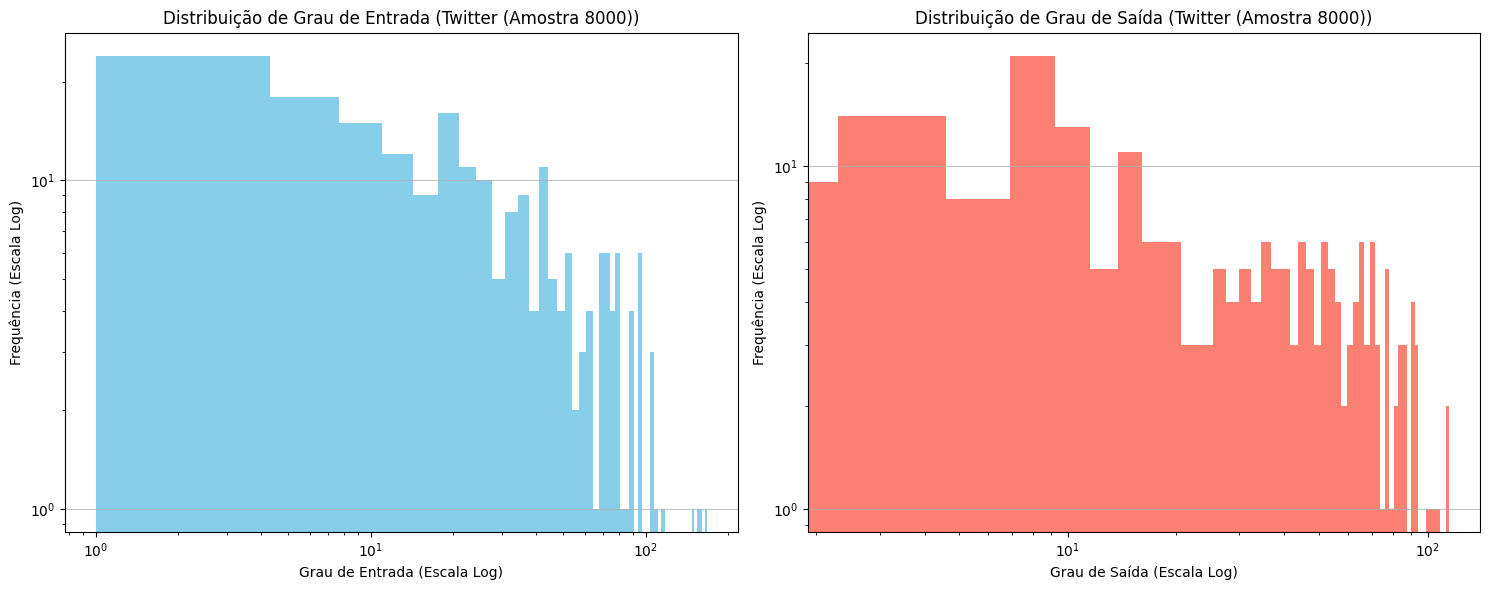

In [41]:
if G is not None and G.number_of_nodes() > 0:

    pagerank_valores, top_influenciadores_pagerank = calcular_pagerank(G)

    particao_comunidades_dict = detectar_comunidades_louvain(G)

    graus_entrada_dict, graus_saida_dict = calcular_centralidade_grau(G)
    intermediacao_dict = calcular_centralidade_intermediacao(G)
    proximidade_dict = calcular_centralidade_proximidade(G)
    
    # Plotar Distribuição de Graus
    nome_do_grafo_atual = f"Twitter (Amostra {NUM_LINHAS_AMOSTRA})" if USAR_AMOSTRA_PROCESSAMENTO else "Twitter (Completo)"
    plotar_distribuicao_graus(G, nome_grafo=nome_do_grafo_atual)

else:
    print("Grafo G não está carregado ou está vazio. Análises não podem ser executadas.")

## Parte 4: Análise dos Datasets de Notícias

Carregamos os datasets de notícias para uma análise descritiva básica, com seu conteúdo e estruturas

In [ ]:
try:
    df_true = pd.read_csv(ARQUIVO_TRUE_NEWS)
    df_fake = pd.read_csv(ARQUIVO_FAKE_NEWS)

    print("--- Visão Geral do Dataset de Notícias Verdadeiras ---")
    print(f"Formato: {df_true.shape}")
    print(f"Colunas: {df_true.columns.tolist()}")
    print(f"Primeiras 5 linhas:\n{df_true.head()}")
    print(f"\nDistribuição por 'subject':\n{df_true['subject'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")

    print("\n\n--- Visão Geral do Dataset de Notícias Falsas ---")
    print(f"Formato: {df_fake.shape}")
    print(f"Colunas: {df_fake.columns.tolist()}")
    print(f"Primeiras 5 linhas:\n{df_fake.head()}")
    print(f"\nDistribuição por 'subject':\n{df_fake['subject'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'}")


except FileNotFoundError:
    print("ERRO: Um ou ambos os arquivos de notícias (True.csv, fake.csv) não foram encontrados. Verifique os caminhos.")
except Exception as e:
    print(f"Erro ao processar arquivos de notícias: {e}")

--- Visão Geral do Dataset de Notícias Verdadeiras ---
Formato: (21417, 4)
Colunas: ['title', 'text', 'subject', 'date']
Primeiras 5 linhas:
                                               title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   
2  Senior U.S. Republican senator: 'Let Mr. Muell...   
3  FBI Russia probe helped by Australian diplomat...   
4  Trump wants Postal Service to charge 'much mor...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   
2  WASHINGTON (Reuters) - The special counsel inv...  politicsNews   
3  WASHINGTON (Reuters) - Trump campaign adviser ...  politicsNews   
4  SEATTLE/WASHINGTON (Reuters) - President Donal...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   
2  December 31, 2017   
3  De

In [43]:

def plotar_subgrafo_comunidade(G, partition_dict, community_id_alvo, layout_func=nx.spring_layout, **kwargs):
    
#plota a subcomunidade de G, com id específico

    if G.number_of_nodes() == 0:
        print("Grafo original vazio.")
        return
    if not partition_dict:
        print("Dicionário de partição de comunidades não fornecido.")
        return

    nodes_na_comunidade_alvo = [node for node, comm_id in partition_dict.items() if comm_id == community_id_alvo]

    if not nodes_na_comunidade_alvo:
        print(f"Nenhum nó encontrado para a comunidade ID {community_id_alvo}.")
        return

    subgrafo_comunidade = G.subgraph(nodes_na_comunidade_alvo)

    print(f"\nPlotando subgrafo para a Comunidade ID: {community_id_alvo}")
    print(f"  Número de Nós no Subgrafo: {subgrafo_comunidade.number_of_nodes()}")
    print(f"  Número de Arestas no Subgrafo: {subgrafo_comunidade.number_of_edges()}")

    if subgrafo_comunidade.number_of_nodes() == 0:
        print("Subgrafo da comunidade está vazio.")
        return
        
    plt.figure(figsize=(10, 8))


    if layout_func == nx.spring_layout:
        pos_subgrafo = layout_func(subgrafo_comunidade, seed=42, **kwargs)
    else: 
        pos_subgrafo = layout_func(subgrafo_comunidade, **kwargs)


    node_colors_subgrafo = [G.nodes[n].get('community_id', 0) for n in subgrafo_comunidade.nodes()]
    node_sizes_subgrafo = [G.nodes[n].get('pagerank', 0.00001) * 30000 for n in subgrafo_comunidade.nodes()]

    nx.draw_networkx_edges(subgrafo_comunidade, pos_subgrafo, alpha=0.3, width=0.7)
    nx.draw_networkx_nodes(subgrafo_comunidade, pos_subgrafo,
                           node_color='skyblue', # específica para a comunidade
                           node_size=node_sizes_subgrafo,
                           alpha=0.9)

    if subgrafo_comunidade.number_of_nodes() < 70:
        nx.draw_networkx_labels(subgrafo_comunidade, pos_subgrafo, font_size=9)

    plt.title(f"Visualização da Comunidade ID: {community_id_alvo} ({subgrafo_comunidade.number_of_nodes()} Nós)")
    plt.axis('off')
    plt.show()

## Parte 5: Visualização e exportação para Gephi

In [44]:
def exportar_para_gephi(G, arquivo_saida_gexf):
    print(f"\nExportando grafo para Gephi: {arquivo_saida_gexf}")
    if G is None or G.number_of_nodes() == 0:
        print("Grafo não carregado ou vazio. Nada para exportar.")
        return
        

    for node in G.nodes():
        G.nodes[node]['pagerank'] = G.nodes[node].get('pagerank', 0.0)
        G.nodes[node]['community_id'] = G.nodes[node].get('community_id', -1) # -1 para nós sem comunidade
        G.nodes[node]['grau_entrada'] = G.nodes[node].get('grau_entrada', 0)
        G.nodes[node]['grau_saida'] = G.nodes[node].get('grau_saida', 0)
        G.nodes[node]['centralidade_intermediacao'] = G.nodes[node].get('centralidade_intermediacao', 0.0)
        G.nodes[node]['centralidade_proximidade'] = G.nodes[node].get('centralidade_proximidade', 0.0)
        
    try:
        nx.write_gexf(G, arquivo_saida_gexf)
        print(f"Arquivo GEXF '{arquivo_saida_gexf}' gerado com sucesso!")
    except Exception as e:
        print(f"Erro ao exportar para GEXF: {e}")

def plotar_amostra_grafo_matplotlib(G, partition_dict):
    num_nodes_plot = G.number_of_nodes()
    if num_nodes_plot == 0:
        print("Grafo vazio, nada para plotar.")
        return
    if num_nodes_plot > 300: #  Matplotlib limite
        print(f"\nGrafo com {num_nodes_plot} nós. Grande demais para plotar eficientemente com Matplotlib.")
        print("Considere visualizar um subgrafo de uma comunidade específica ou usar o Gephi para a rede completa.")
        return

    print("\nPlotando grafo (ou amostra) com Matplotlib...")
    plt.figure(figsize=(15, 12))
    
    
    node_colors = [partition_dict.get(n, 0) for n in G.nodes()] if partition_dict else 'skyblue'
    num_unique_colors = len(set(node_colors)) if partition_dict else 1
    
    
    node_sizes = [G.nodes[n].get('pagerank', 0.00001) * 30000 for n in G.nodes()] # ajustar o multiplicador se necessário

    pos = nx.spring_layout(G, k=0.5/((num_nodes_plot**0.5) or 1), iterations=30, seed=42)

    nx.draw_networkx_edges(G, pos, alpha=0.1, width=0.5)
    nodes_drawn = nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, 
                                         cmap=plt.cm.get_cmap('tab20', max(1, num_unique_colors)),
                                         alpha=0.8)
    
    if num_nodes_plot < 70: # labels apenas para grafos muito pequenos
        nx.draw_networkx_labels(G, pos, font_size=8)
    
    plt.title(f"Visualização do Grafo ({G.number_of_nodes()} Nós, {G.number_of_edges()} Arestas)")
    plt.axis('off')
    plt.show()


Exportando grafo para Gephi: ../dados/grafo_trabalhado.gexf
Arquivo GEXF '../dados/grafo_trabalhado.gexf' gerado com sucesso!

Plotando grafo (ou amostra) com Matplotlib...


C:\Users\marce\AppData\Local\Temp\ipykernel_14464\3160487419.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap=plt.cm.get_cmap('tab20', max(1, num_unique_colors)),


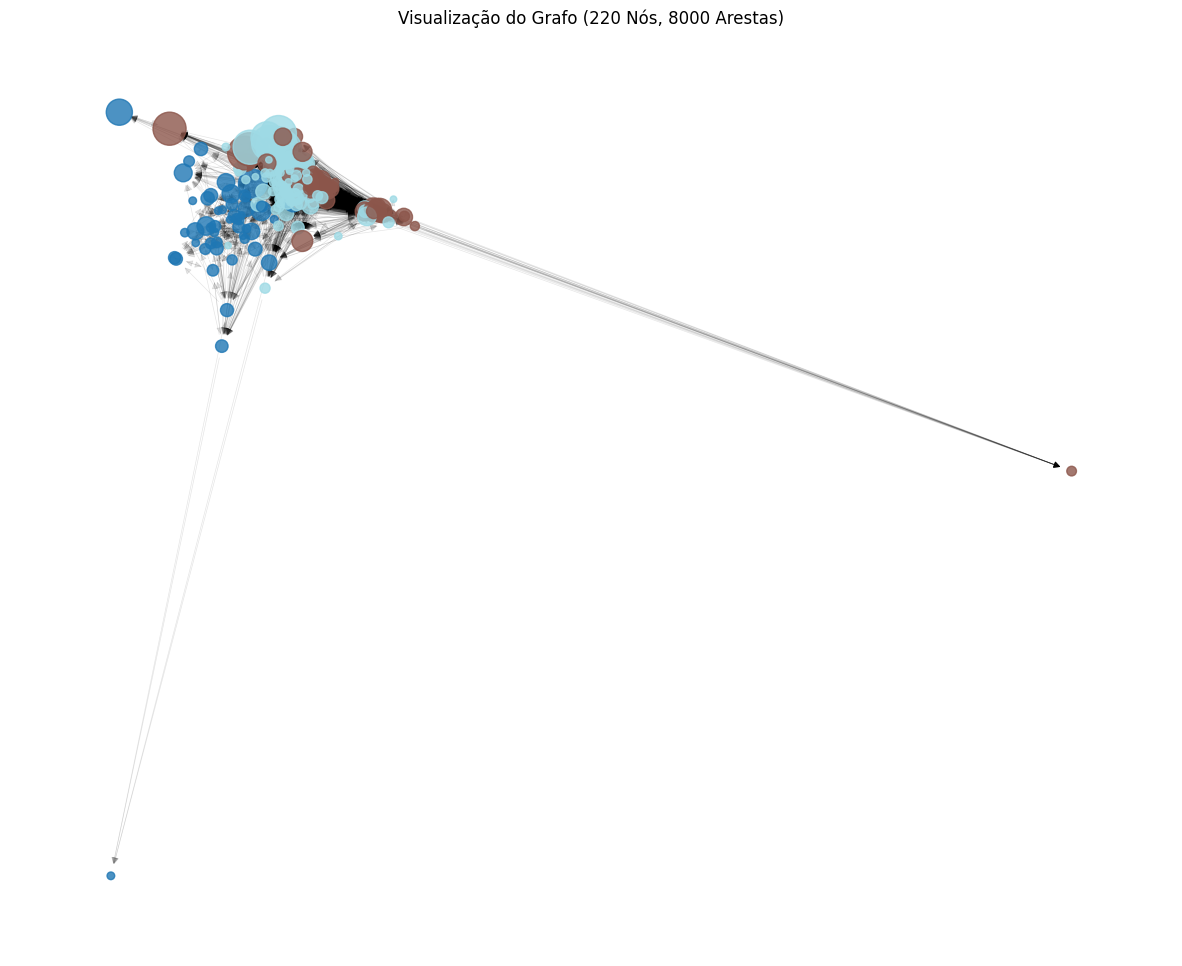

In [45]:
if G is not None:
    
    exportar_para_gephi(G, ARQUIVO_GRAFO_GEPHI)
    
    if 'particao_comunidades_dict' in locals() and particao_comunidades_dict is not None:
        plotar_amostra_grafo_matplotlib(G, particao_comunidades_dict)
    else:
        plotar_amostra_grafo_matplotlib(G, None) # plot sem cores de comunidade se não detectadas
else:
    print("Grafo G não carregado, não é possível exportar ou plotar.")


Tentando plotar comunidade 2 com 87 membros.

Plotando subgrafo para a Comunidade ID: 2
  Número de Nós no Subgrafo: 87
  Número de Arestas no Subgrafo: 1748


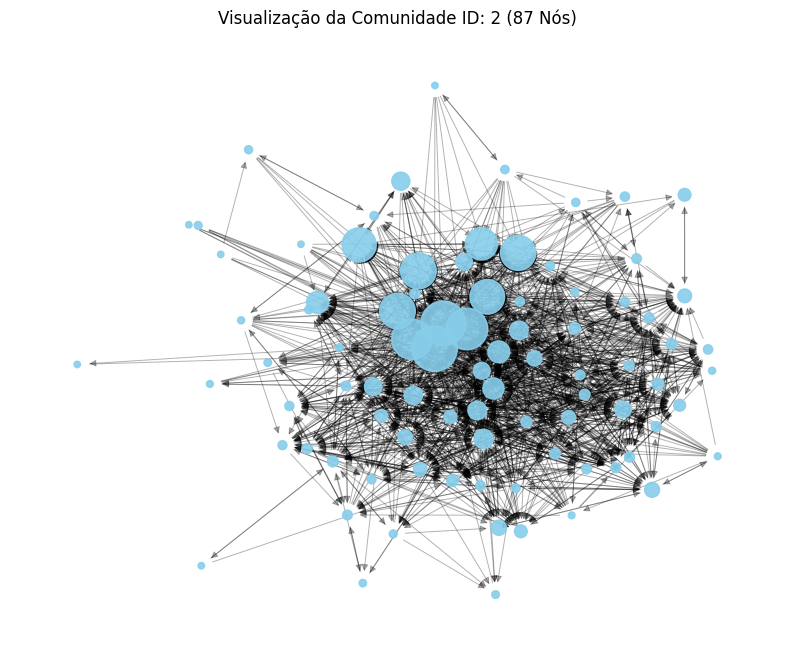

Tentando plotar comunidade 1 com 83 membros.

Plotando subgrafo para a Comunidade ID: 1
  Número de Nós no Subgrafo: 83
  Número de Arestas no Subgrafo: 3022


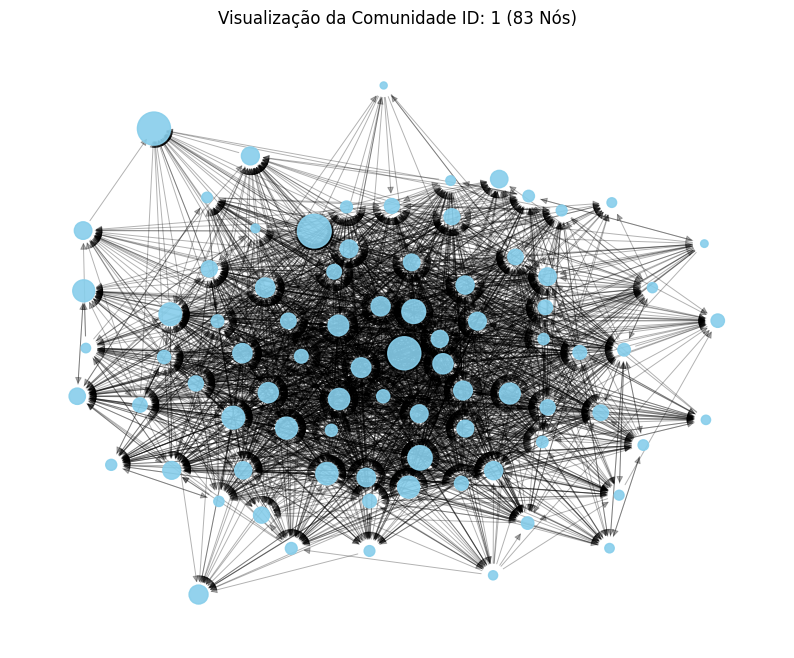

Tentando plotar comunidade 0 com 50 membros.

Plotando subgrafo para a Comunidade ID: 0
  Número de Nós no Subgrafo: 50
  Número de Arestas no Subgrafo: 347


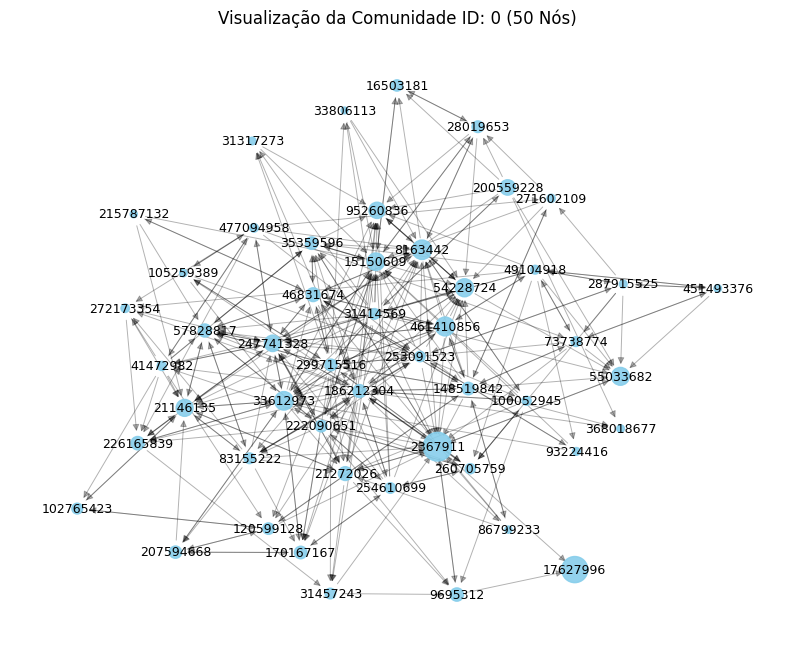

In [46]:
if G is not None and 'particao_comunidades_dict' in locals() and particao_comunidades_dict:
    
    community_counts = collections.Counter(particao_comunidades_dict.values())
    top_3_communities = community_counts.most_common(3) 

    for comm_id, count in top_3_communities:
          print(f"Tentando plotar comunidade {comm_id} com {count} membros.")
          if count < 300: 
               plotar_subgrafo_comunidade(G, particao_comunidades_dict, 
                                       community_id_alvo=comm_id, 
                                       layout_func=nx.kamada_kawai_layout)
          else:
              print(f"Comunidade {comm_id} é muito grande ({count} membros) para plotar com Matplotlib. Use Gephi.")
else:
     print("Grafo ou partição de comunidades não disponíveis para plotar subgrafos.")

In [47]:
def plotar_top_n_usuarios(metric_dict, metrica_nome, top_n=TOP_K_NOS): # TOP_nos

    if not metric_dict:
        print(f"Dicionário da métrica '{metrica_nome}' está vazio ou não foi fornecido.")
        return

    # Ordenar o dicionário top N
    sorted_metric = sorted(metric_dict.items(), key=lambda item: item[1], reverse=True)
    top_items = sorted_metric[:top_n]

    if not top_items:
        print(f"Nenhum item para plotar para a métrica '{metrica_nome}'.")
        return

    nodes = [str(item[0]) for item in top_items] # Converte IDs dos nós para string para o plot
    scores = [item[1] for item in top_items]

    plt.figure(figsize=(12, 7)) # Ajuste o tamanho 
    bars = plt.barh(nodes, scores, color='coral') # 
    plt.xlabel(f'Score de {metrica_nome}')
    plt.ylabel('ID do Usuário')
    plt.title(f'Top {top_n} Usuários por {metrica_nome}')
    plt.gca().invert_yaxis() # Mostrar o maior score no topo


    for bar in bars:
        plt.text(bar.get_width() + (0.01 * max(scores) if max(scores) > 0 else 0.01) ,  
                 bar.get_y() + bar.get_height()/2,        
                 f'{bar.get_width():.4f}',                
                 va='center')

    plt.tight_layout()
    plt.show()


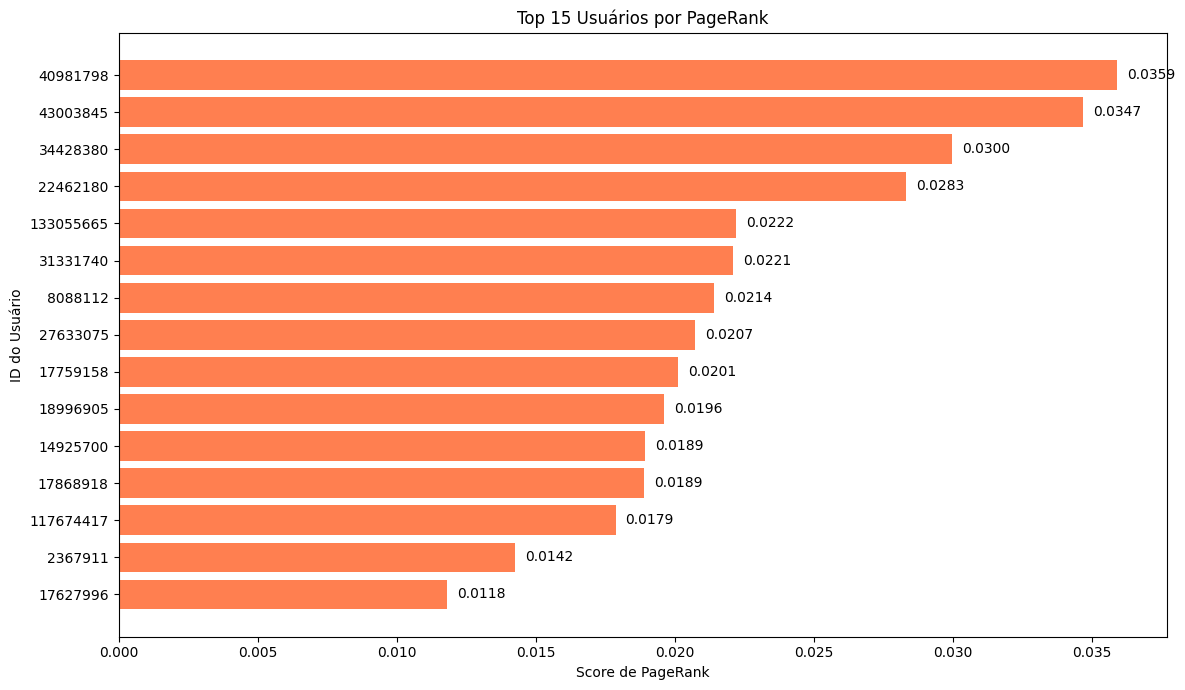

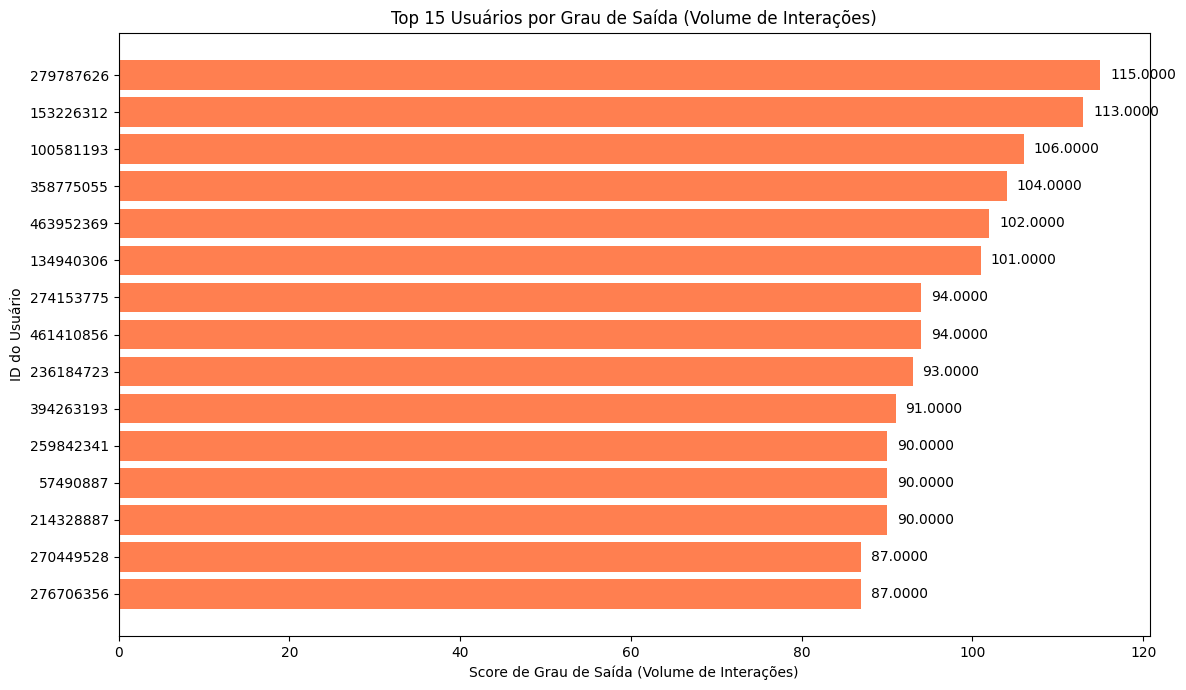

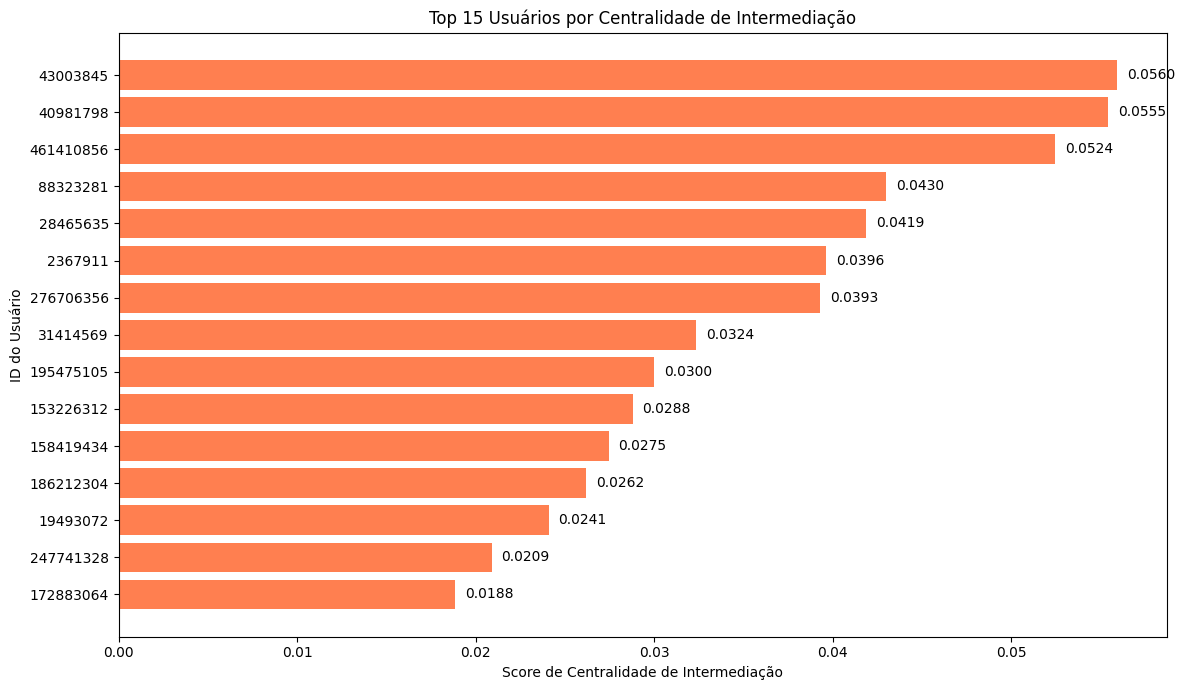

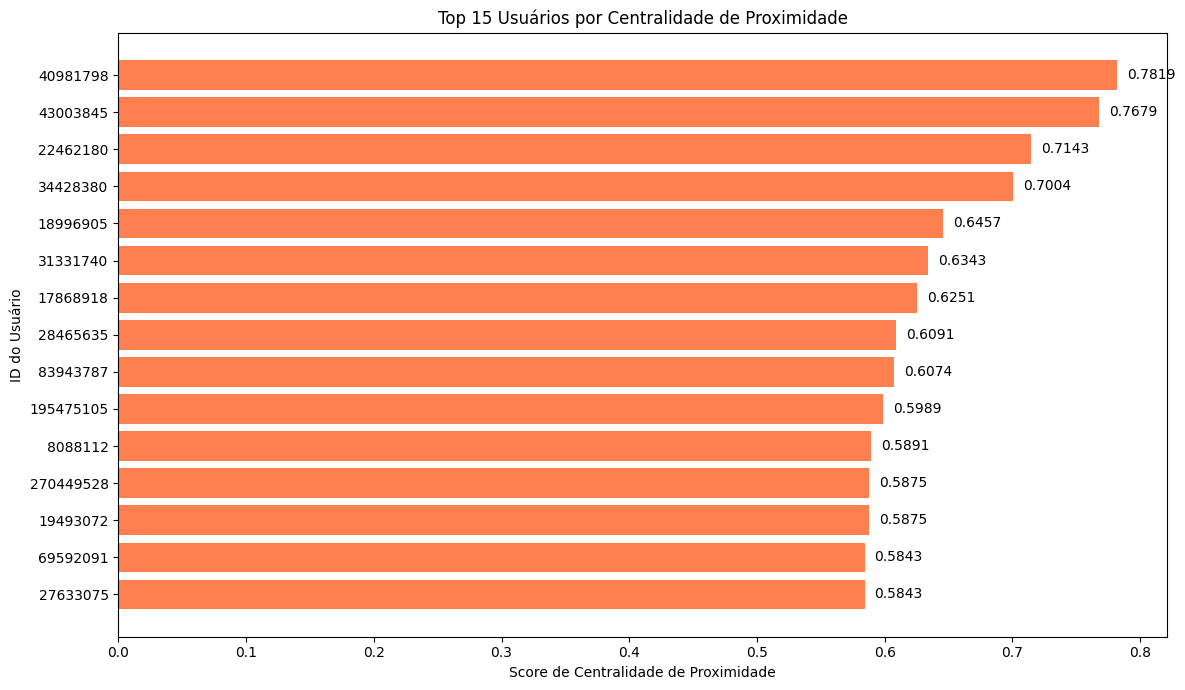

In [48]:
if G is not None and G.number_of_nodes() > 0:
    if 'pagerank_valores' in locals() and pagerank_valores:
        plotar_top_n_usuarios(pagerank_valores, "PageRank")
    
    if 'graus_saida_dict' in locals() and graus_saida_dict:
        plotar_top_n_usuarios(graus_saida_dict, "Grau de Saída (Volume de Interações)")

    if 'intermediacao_dict' in locals() and intermediacao_dict:
        plotar_top_n_usuarios(intermediacao_dict, "Centralidade de Intermediação")

    if 'proximidade_dict' in locals() and proximidade_dict:
        plotar_top_n_usuarios(proximidade_dict, "Centralidade de Proximidade")
else:
    print("Grafo não carregado ou sem nós para plotar top N.")